# Composite mean contours

Composites of salinity contours based on strong and weak SPG state. The strong and weak SPG state is based on +/-1 standard deviation of the respective SPG index. Here: `SPGI`, `FKL` and `DENS` (not detrended) from 1993 to 2016.

In [1]:
import numpy as np
import xarray as xr
import pandas as pd

from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap

%matplotlib inline

### Load HadOBS EN4 salinity and indices

In [2]:
ds = xr.open_dataset('/home/jet/data/hadobs/converted/en4/salinity.nc')

In [3]:
df_spgi = pd.read_csv('../indices/SPGI.csv')
df_fkl = pd.read_csv('../indices/FKL.csv')
df_dens = pd.read_csv('../indices/DENS.csv')

In [4]:
df_spgi.time = pd.DatetimeIndex(df_fkl.time)
df_spgi = df_spgi.set_index(['time'])

df_fkl.time = pd.DatetimeIndex(df_fkl.time)
df_fkl = df_fkl.set_index(['time'])

df_dens.time = pd.DatetimeIndex(df_dens.time)
df_dens = df_dens.set_index(['time'])

### Set temporal and spatial ranges

In [5]:
tstart = '1993-01-15'
tend = '2016-12-15'

south = 10
north = 80
west = -80
east = 30

### Subsample salinty and indices

In [6]:
psal = ds.salinity.sel(time=slice(tstart,tend),lat=slice(south,north),lon=slice(west,east))

In [7]:
df_spgi = df_spgi[(df_spgi.index>=tstart) & (df_spgi.index<=tend)]
df_fkl = df_fkl[(df_fkl.index>=tstart) & (df_fkl.index<=tend)]
df_dens = df_dens[(df_dens.index>=tstart) & (df_dens.index<=tend)]

In [8]:
df = pd.DataFrame(df_spgi.reset_index().time)
df.time = pd.DatetimeIndex(df.time)

In [9]:
df['spgi'] = df_spgi.reset_index().SPGI
df['fkl'] = df_fkl.reset_index().fkl
df['dens'] = df_dens.reset_index().DENS

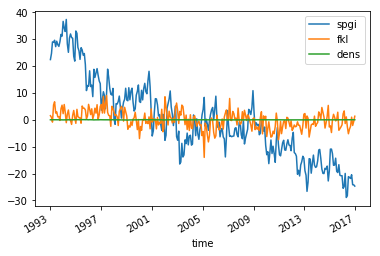

In [10]:
df.set_index(['time']).plot()

### Depth-average salinity (top 491 m)

In [11]:
upper = 0
lower = 500

In [12]:
depth_bnds = ds.depth_bnds.sel(depth=slice(upper,lower))

In [13]:
print 'upper:',  str(depth_bnds[0,0].values)
print 'lower:', str(depth_bnds[-1,1].values)

upper: 0.0
lower: 490.9494


In [14]:
dz = (depth_bnds[:,1]-depth_bnds[:,0])

In [15]:
H = ((psal/psal)*dz).sum('depth')

In [16]:
psal_avg = (psal * dz).sum('depth')/H

### Calculate annual means

#### Salinity

In [17]:
psal_annual = psal_avg.groupby('time.year').mean('time')

#### SPGI

In [18]:
df['year'] = pd.DatetimeIndex(df.time).year

In [19]:
df_annual = df[['year','spgi','fkl','dens']].groupby(['year']).mean()

### Normalize DENS index

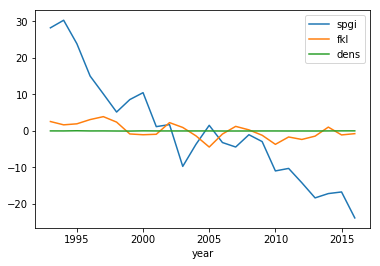

In [20]:
#df.plot()
df_annual.plot()

In [21]:
df_annual['spgi_norm'] = (df_annual.spgi - np.mean(df_annual.spgi))/np.std(df_annual.spgi)
df_annual['fkl_norm'] = (df_annual.fkl - np.mean(df_annual.fkl))/np.std(df_annual.fkl)
df_annual['dens_norm'] = (df_annual.dens - np.mean(df_annual.dens))/np.std(df_annual.dens)

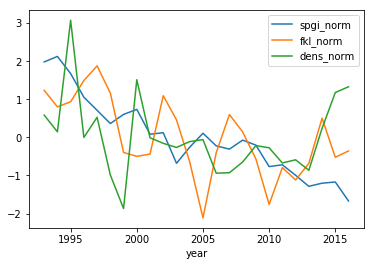

In [22]:
#df.drop(['SPGI'], axis=1).plot()
df_annual.drop(['spgi','fkl','dens'], axis=1).plot()

### Find strong and weak SPG years based on +/-1 standard deviation of normalized timeseries
- Select all years for strong SPG: DENS_norm > 1.0
- Select all years for weak SPG: DENS_norm < -1.0

In [23]:
idx_strong_spgi = np.where(df_annual.spgi_norm > 1.0)
idx_strong_fkl = np.where(df_annual.fkl_norm > 1.0)
idx_strong_dens = np.where(df_annual.dens_norm > 1.0)

In [24]:
idx_weak_spgi = np.where(df_annual.spgi_norm < -1.0)
idx_weak_fkl = np.where(df_annual.fkl_norm < -1.0)
idx_weak_dens = np.where(df_annual.dens_norm < -1.0)

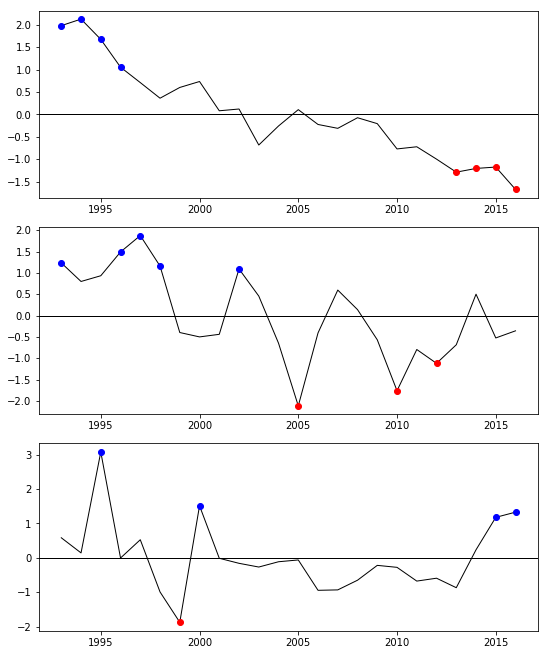

In [25]:
f, axes = plt.subplots(3, 1, figsize=(8,10))
f.tight_layout()
plt.subplots_adjust(top=0.9, left=0.1)

plt.subplot(3, 1, 1)
plt.axhline(0, color='black', lw=1)
plt.plot(df_annual.index, df_annual.spgi_norm, lw=1, linestyle='-', c='k')

plt.plot(np.where(df_annual.spgi_norm > 1.0, df_annual.index, np.nan), 
         np.where(df_annual.spgi_norm > 1.0, df_annual.spgi_norm, np.nan), 
         marker='.', c='b',ms=12,linestyle='none')
plt.plot(np.where(df_annual.spgi_norm < -1.0, df_annual.index, np.nan), 
         np.where(df_annual.spgi_norm < -1.0, df_annual.spgi_norm, np.nan), 
         marker='.', c='r',ms=12,linestyle='none')

plt.subplot(3, 1, 2)
plt.axhline(0, color='black', lw=1)
plt.plot(df_annual.index, df_annual.fkl_norm, lw=1, linestyle='-', c='k')

plt.plot(np.where(df_annual.fkl_norm > 1.0, df_annual.index, np.nan), 
         np.where(df_annual.fkl_norm > 1.0, df_annual.fkl_norm, np.nan), 
         marker='.', c='b',ms=12,linestyle='none')
plt.plot(np.where(df_annual.fkl_norm < -1.0, df_annual.index, np.nan), 
         np.where(df_annual.fkl_norm < -1.0, df_annual.fkl_norm, np.nan), 
         marker='.', c='r',ms=12,linestyle='none')

plt.subplot(3, 1, 3)
plt.axhline(0, color='black', lw=1)
plt.plot(df_annual.index, df_annual.dens_norm, lw=1, linestyle='-', c='k')

plt.plot(np.where(df_annual.dens_norm > 1.0, df_annual.index, np.nan), 
         np.where(df_annual.dens_norm > 1.0, df_annual.dens_norm, np.nan), 
         marker='.', c='b',ms=12,linestyle='none')
plt.plot(np.where(df_annual.dens_norm < -1.0, df_annual.index, np.nan), 
         np.where(df_annual.dens_norm < -1.0, df_annual.dens_norm, np.nan), 
         marker='.', c='r',ms=12,linestyle='none')

plt.show()

### Average salinity fields for strong and weak SPG

In [26]:
psal_strong_spgi = psal_annual[idx_strong_spgi].mean(['year'])
psal_strong_fkl = psal_annual[idx_strong_fkl].mean(['year'])
psal_strong_dens = psal_annual[idx_strong_dens].mean(['year'])

In [27]:
psal_weak_spgi = psal_annual[idx_weak_spgi].mean(['year'])
psal_weak_fkl = psal_annual[idx_weak_fkl].mean(['year'])
psal_weak_dens = psal_annual[idx_weak_dens].mean(['year'])

### Map contours

In [28]:
south = 37
north = 63
west = -61
east = 0

In [29]:
levels = [35.20,35.30,35.40,35.50]

In [30]:
lon, lat = np.meshgrid(psal_annual.lon.values, psal_annual.lat.values)

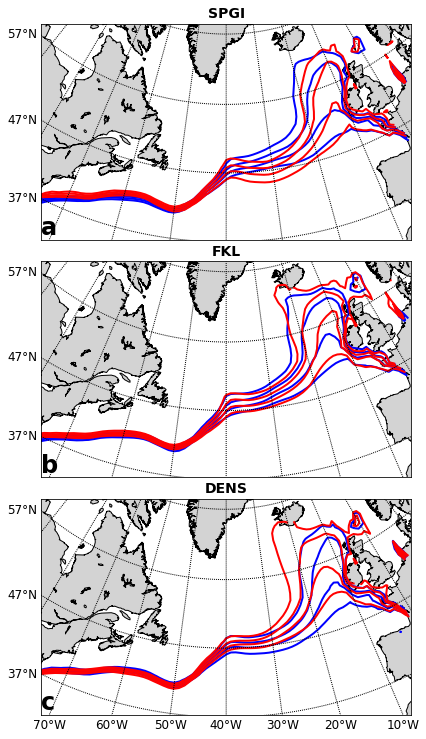

In [34]:
f, axes = plt.subplots(3, 1, sharey=True, figsize=(10,12))
f.tight_layout()
f.subplots_adjust(right=0.9, left=0.1, bottom=0.1, top=0.9, wspace=0, hspace=0.1)

plt.subplot(3, 1, 1)
plt.title('SPGI', fontsize=14, fontweight='bold')
m = Basemap(width=6000000,height=3500000,
            rsphere=(6378137.00,6356752.3142),\
            resolution='l',area_thresh=1000.,projection='lcc',\
            lat_1=45.,lat_2=55,lat_0=53,lon_0=-40.)
m.fillcontinents(color='lightgrey')
m.drawcoastlines()
m.drawparallels(np.arange(-90-3,90,10), labels=[1,0,0,0],fontsize=12)
m.drawmeridians(np.arange(0,360,10), labels=[0,0,0,0],fontsize=12)
x, y = m(lon, lat)
p = m.contour(x, y, psal_strong_spgi,levels=levels, colors='b',linewidths=2)
p = m.contour(x, y, psal_weak_spgi,levels=levels, colors='r',linewidths=2)
plt.text(10, 55, 'a', fontsize=24, fontweight='bold', va='bottom')

plt.subplot(3, 1, 2)
plt.title('FKL', fontsize=14, fontweight='bold')
m = Basemap(width=6000000,height=3500000,
            rsphere=(6378137.00,6356752.3142),\
            resolution='l',area_thresh=1000.,projection='lcc',\
            lat_1=45.,lat_2=55,lat_0=53,lon_0=-40.)
m.fillcontinents(color='lightgrey')
m.drawcoastlines()
m.drawparallels(np.arange(-90-3,90,10), labels=[1,0,0,0],fontsize=12)
m.drawmeridians(np.arange(0,360,10), labels=[0,0,0,0],fontsize=12)
x, y = m(lon, lat)
p = m.contour(x, y, psal_strong_fkl, levels=levels, colors='b', linewidths=2)
p = m.contour(x, y, psal_weak_fkl, levels=levels, colors='r', linewidths=2)
plt.text(10, 55, 'b', fontsize=24, fontweight='bold', va='bottom')

plt.subplot(3, 1, 3)
plt.title('DENS', fontsize=14, fontweight='bold')
m = Basemap(width=6000000,height=3500000,
            rsphere=(6378137.00,6356752.3142),\
            resolution='l',area_thresh=1000.,projection='lcc',\
            lat_1=45.,lat_2=55,lat_0=53,lon_0=-40.)
m.fillcontinents(color='lightgrey')
m.drawcoastlines()
m.drawparallels(np.arange(-90-3,90,10), labels=[1,0,0,0],fontsize=12)
m.drawmeridians(np.arange(0,360,10), labels=[0,0,0,1],fontsize=12)
x, y = m(lon, lat)
p = m.contour(x, y, psal_strong_dens, levels=levels, colors='b', linewidths=2)
p = m.contour(x, y, psal_weak_dens, levels=levels, colors='r', linewidths=2)
plt.text(10, 55, 'c', fontsize=24, fontweight='bold', va='bottom')

plt.savefig('/tmp/figure.png')
plt.savefig('/tmp/figure.eps')
plt.show()

In [35]:
ds_psal_spgi = xr.Dataset({'psal_strong_spgi': (['lat', 'lon'], psal_strong_spgi),
                           'psal_weak_spgi': (['lat', 'lon'], psal_weak_spgi)},
                          coords={'lon': psal_strong_spgi.lon.values,'lat': psal_strong_spgi.lat.values})

In [36]:
ds_psal_spgi.to_netcdf('fig02_psal_spgi.nc', format='NETCDF4',
                       encoding={'psal_weak_spgi': {'dtype': 'float32', 'zlib': True},
                                 'psal_strong_spgi': {'dtype': 'float32', 'zlib': True}})